In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

## Loading in base data

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

giants
Number of stars in selected sample: 23789


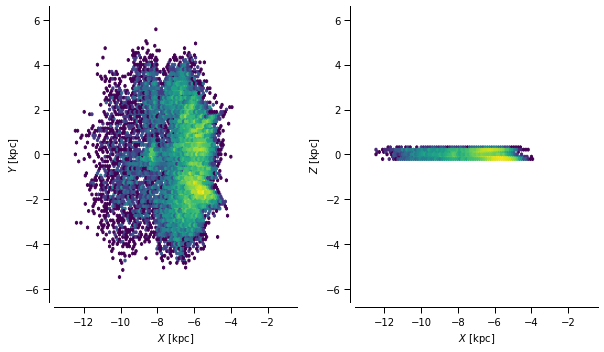

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars

filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)


print(fit_save_location[-len(filter_of_choice):])

###

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 300
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


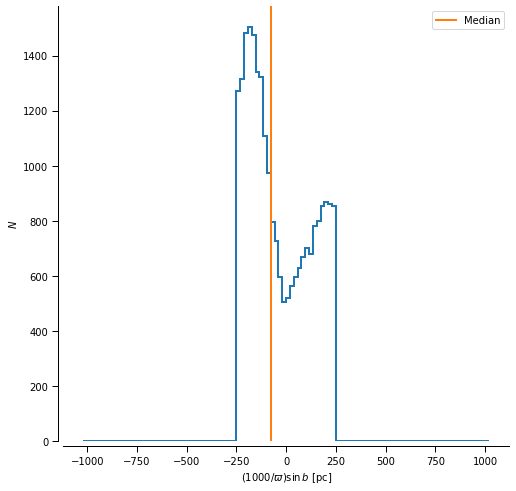

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [12]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    

base_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

improved_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2_giants_std.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy_vector', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':np.nan, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp_model_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_2_giants_std_nov0.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy_vector', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':np.nan, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp2_3_model_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_nov0.stan',
                'npars': 11,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }

vdisp_function_bp2_3_model_with_v0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0.stan',
                'npars': 12,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0','amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }


vdisp_function_bp2_3_model_with_v0_no_vdisp = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0_no_vdisp2.stan',
                'npars': 6,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan}
                }

vdisp_function_bp2_3_model_with_v0_classic_vdisp = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0_classic_vdisp.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }
                # Deze is nu onlogisch: aanpassen. --> Alleen stanfile moet nog aangepast worden.
#                 no_vdisp.stan is nu een nutteloos bestand (dat was de verkeerde weglating van vdisp)


stan_model = vdisp_function_bp2_3_model_with_v0

Number of sources in sample: 300


In [7]:
print(os.getenv('HOME', "not found")) # Prints "not found"

fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
#set_cmdstan_path(os.path.join(os.getenv('HOME'), 'cmdstan')) # Does not work on windows
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0')) # Needs to be replaced with cmdstan location on other Windows devices
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500    
nsampling = 1000 # Deze kan omhoog als hij nog niet convergeerd, maar dat wel gaat doen. Hoger dan convergeerwaarde heeft geen zin.
nchains = 4    

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fgkm_fit = fgkm_model.sample(show_console=False, max_treedepth=20, chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook', output_dir=fit_save_location)
#fgkm_fit = fgkm_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=fgkm_data_path, save_warmup=False, show_progress='notebook')


# init documentation: (=inits in cmdstanpy)
# https://mc-stan.org/cmdstanr/reference/model-method-sample.html 

not found


18:56:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:19:28 - cmdstanpy - INFO - CmdStan done processing.
21:19:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: rotcurve_bp2_3_giants_std_with_v0_model_namespace::log_prob: scov is not positive definite. (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_with_v0.stan', line 174, column 2 to column 21)
	Exception: rotcurve_bp2_3_giants_std_with_v0_model_namespace::log_prob: scov is not positive definite. (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_with_v0.stan', line 174, column 2 to column 21)
	Exception: rotcurve_bp2_3_giants_std_with_v0_model_namespace::log_prob: scov is not positive definite. (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_with_v0.stan', line 174, column 2 to column 21)
	Exception: rotcurve_bp2_3_giants_std_with_v0_model_namespace::log_prob: scov is not positive definite. (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/

21:19:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 14 divergent transitions (1.4%)
	Use function "diagnose()" to see further information.


In [11]:
import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 1500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

Don't forget to erase older .csv and .txt files from the fitfiles folder, when loading the new models.

https://www.wolframalpha.com/input?i=gamma%28alpha%3D1.1%2C+beta%3D10%29
https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample


In [8]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+6]

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1037.320000,54.650200,434.568000,-1002.590000,-997.370000,-994.277000,63.2313,0.007449,1.033800
h_param,0.065787,0.001089,0.070799,0.002799,0.042083,0.208624,4224.1800,0.497602,0.999926
p_param,-2.749280,0.023914,0.806458,-4.192530,-2.677700,-1.574410,1137.2600,0.133968,1.004920
Vsun_pec_x,18.686700,0.378359,5.467690,10.729600,18.944800,26.616500,208.8330,0.024600,1.019950
Vsun_pec_y,41.518500,0.697974,5.955560,36.139700,42.157400,47.448600,72.8059,0.008576,1.044340
Vsun_pec_z,7.765810,0.067623,1.242530,5.860880,7.718660,9.669640,337.6190,0.039771,1.008240
amplitude_x,119.369000,1.620570,23.501000,106.998000,117.642000,129.620000,210.2990,0.024773,1.016860
amplitude_y,75.795300,2.373850,23.492400,61.257600,73.832200,88.253400,97.9369,0.011537,1.027600
amplitude_z,71.517000,0.255207,8.888180,58.659100,71.078200,85.409200,1212.9400,0.142882,1.001820
R_scale_x,9.499610,0.385027,3.215460,7.775850,9.147770,10.910300,69.7438,0.008216,1.036350


In [9]:
fgkm_fit.diagnose()

"Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230416185622_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230416185622_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230416185622_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230416185622_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n16 of 4000 (0.40%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta clos

['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z']
h_param = 0.0+0.1-0.0
p_param = -2.7+0.7-0.8
Vsun_pec_x = 18.9+4.7-4.7
Vsun_pec_y = 42.2+3.1-3.3
Vsun_pec_z = 7.7+1.1-1.1
v0 = 233.4+20.2-20.6
amplitude_x = 117.6+7.1-6.5
amplitude_y = 73.8+8.4-8.0
amplitude_z = 71.1+8.1-7.3
R_scale_x = 9.1+1.0-0.9
R_scale_y = 4.7+0.6-0.5
R_scale_z = 5.5+0.5-0.4


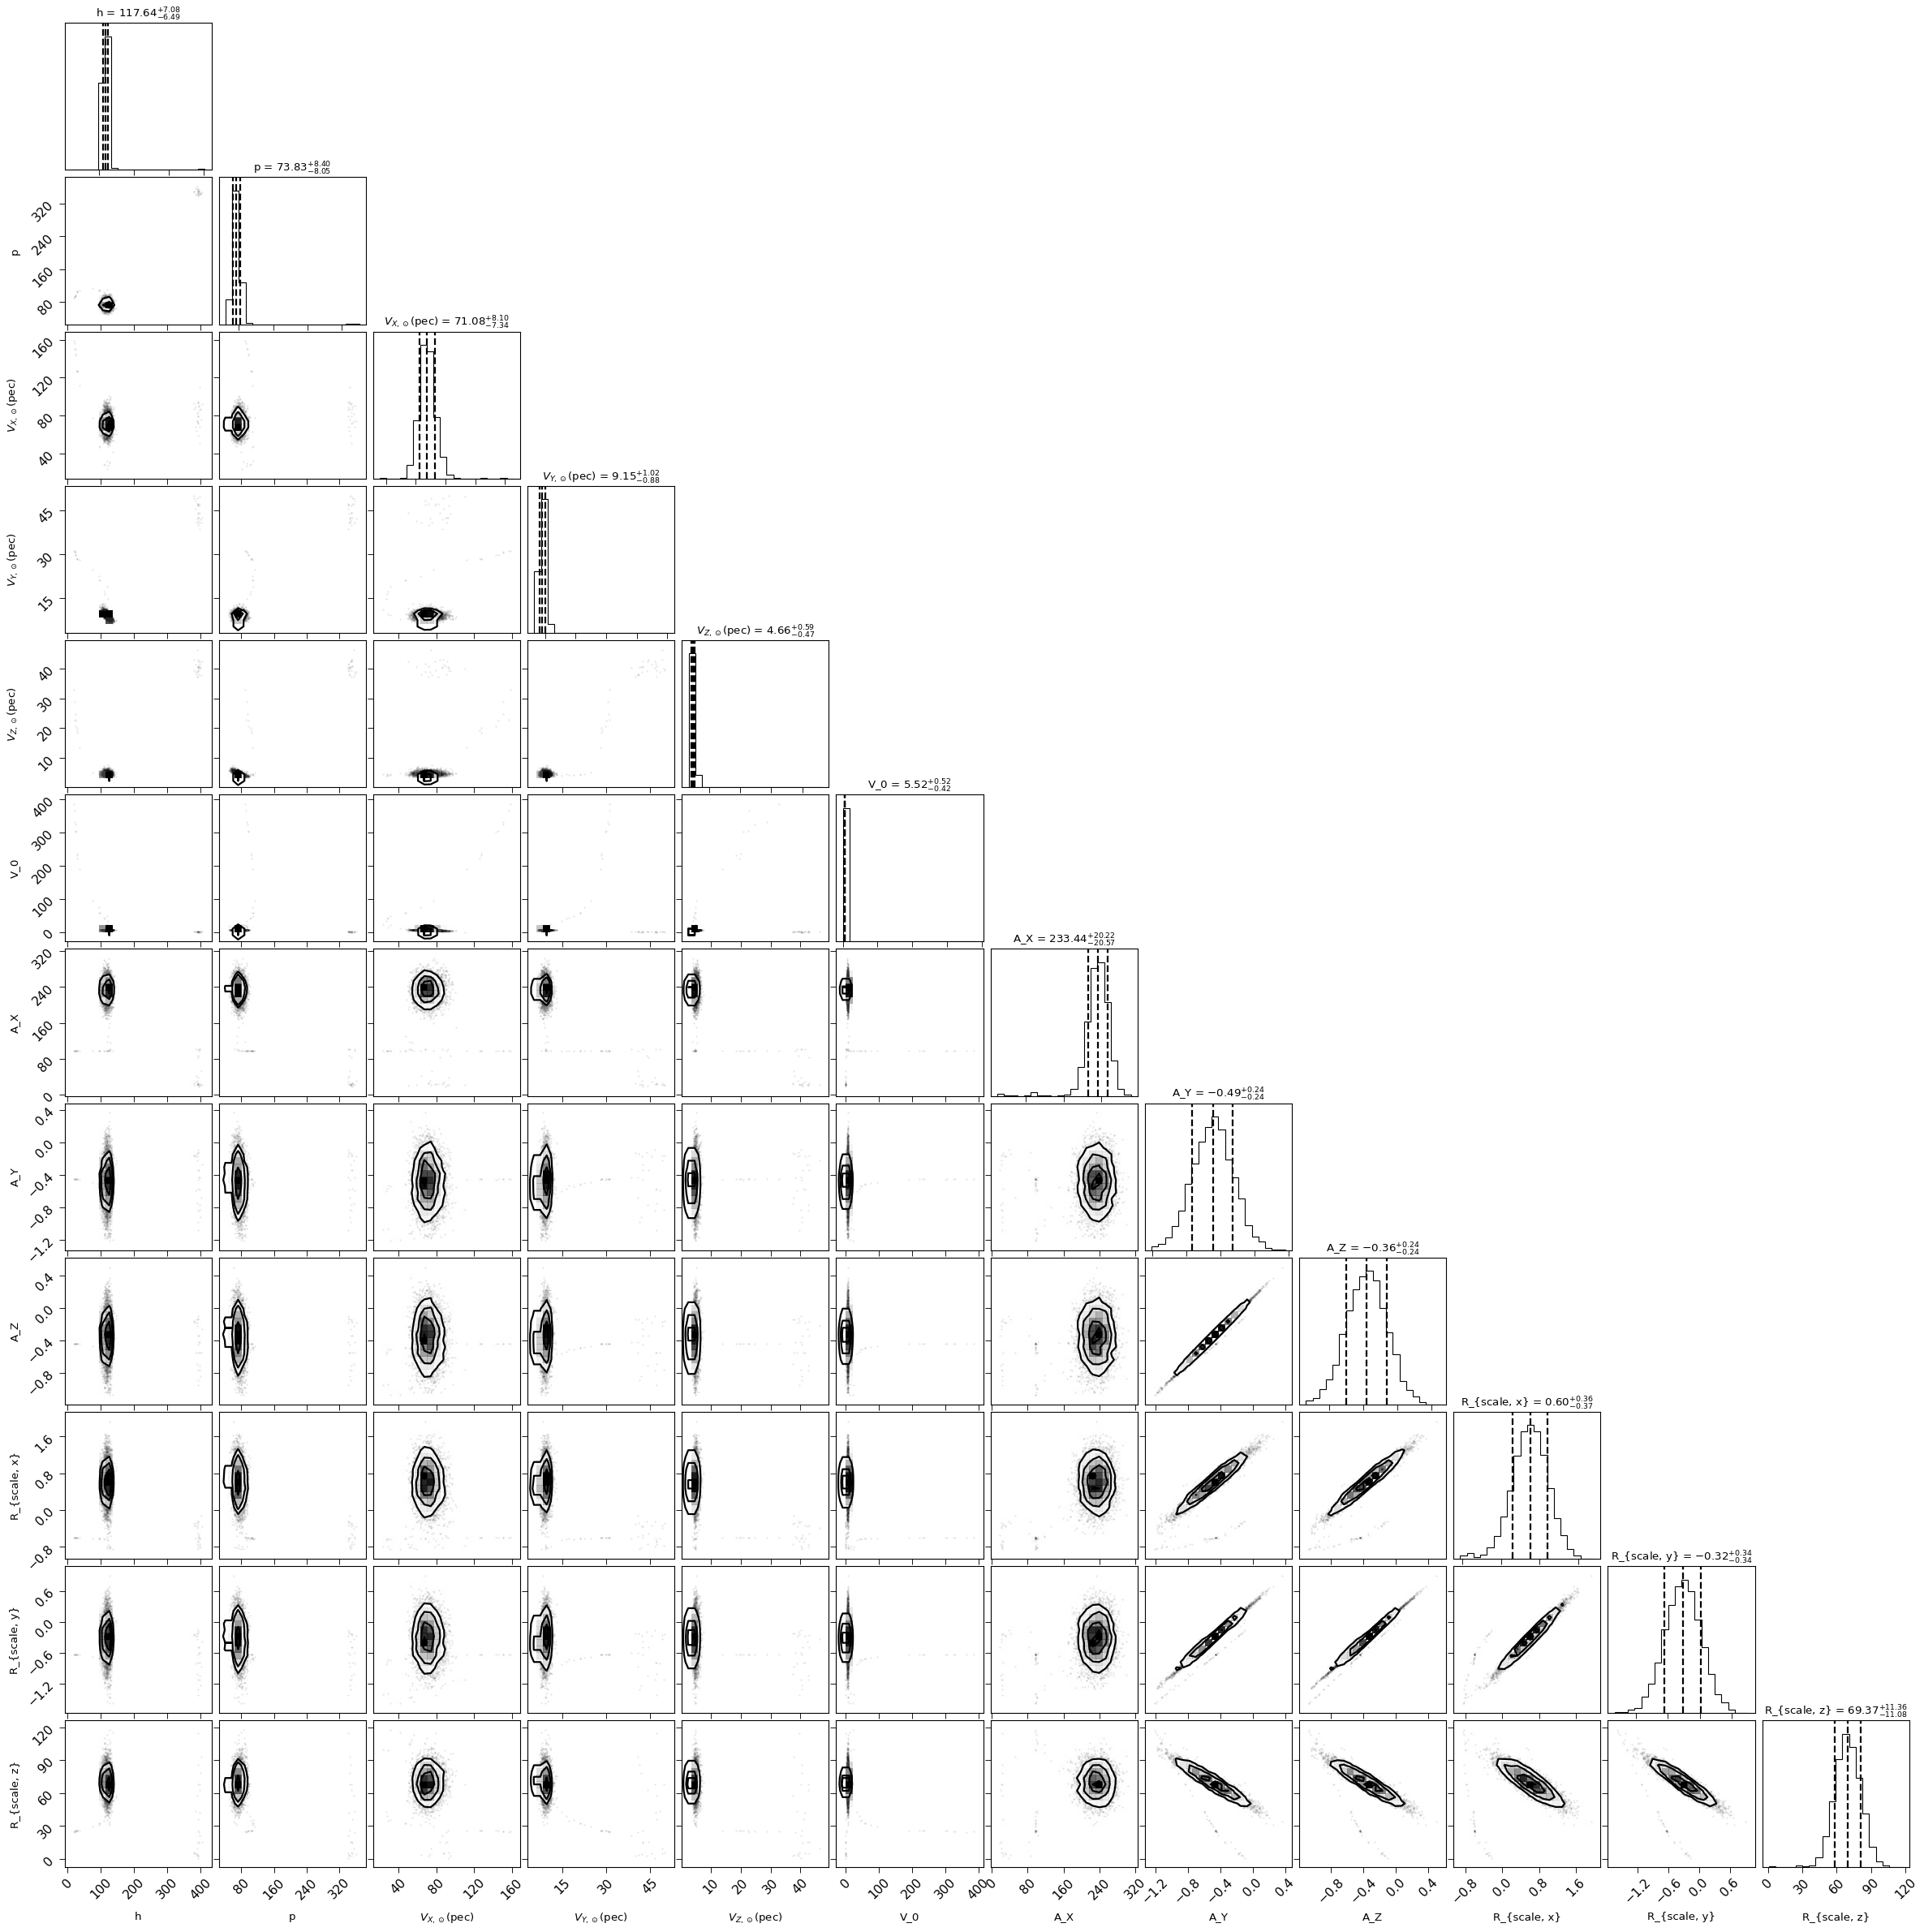

{'h_param': 0.0420598, 'p_param': -2.6778500000000003, 'Vsun_pec_x': 18.94385, 'Vsun_pec_y': 42.15705, 'Vsun_pec_z': 7.7181999999999995, 'v0': 233.438, 'amplitude_x': 117.64150000000001, 'amplitude_y': 73.83, 'amplitude_z': 71.07595, 'R_scale_x': 9.147079999999999, 'R_scale_y': 4.657845, 'R_scale_z': 5.5164100000000005}
12
[array([119.859, 125.562, 117.553, ..., 113.087, 114.009, 120.349]), array([67.3148, 69.3315, 63.5632, ..., 63.4388, 81.6963, 80.3053]), array([70.7522, 71.0061, 71.806 , ..., 75.5334, 69.5717, 77.9689]), array([ 9.33507,  9.00619,  8.61757, ...,  9.46764, 10.8303 ,  9.76766]), array([4.75922, 5.29917, 5.52221, ..., 5.23707, 4.10461, 3.8359 ]), array([5.40445, 5.71633, 5.59568, ..., 5.71518, 5.52086, 5.20117]), array([225.217, 246.32 , 217.882, ..., 244.471, 262.168, 221.249]), array([-0.332678, -0.922659, -0.172037, ..., -0.695636, -0.32706 ,
       -0.371317]), array([-0.199737 , -0.788437 , -0.0336112, ..., -0.561627 , -0.206785 ,
       -0.258924 ]), array([ 0.86

In [13]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(12, 12+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

# Number of draws is very low
print(stan_model['best_params'])
print(len(sample_lists))
print(sample_lists)
print(samples)
print(len(samples)) # 4000 samples

## Using an exponential function to model the dispersion of the giants in x, y and z

In [14]:
def exponential_function(R, amplitude, R_scale):
    return amplitude * np.exp(-(R-2.5)/R_scale)

In [17]:
xxx = np.linspace(0, 14)
amplitude = 80
R_scale = 10
for i in range(len(xxx)):
    if xxx[i] < 2.5:
        yyy[i] = amplitude
    else:
        yyy[i] = exponential_function(xxx[i], amplitude, R_scale)

(0.0, 90.0)

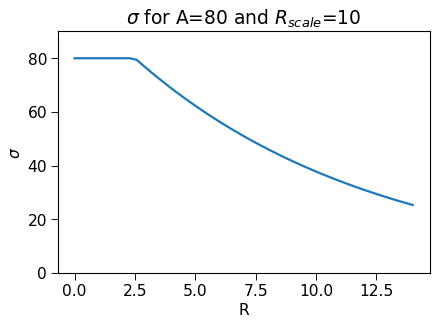

In [18]:
plt.plot(xxx, yyy)
plt.title('$\sigma$ for A={} and $R_{}$={}'.format(amplitude, '{scale}', R_scale))
plt.xlabel('R')
plt.ylabel('$\sigma$')
plt.ylim(0,90)

## Finding the correct formula for the dispersion of the giants

y_max at: 0.10599098256719744
at x=2.5, y= 75.62337832983363


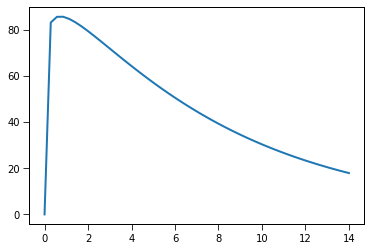

In [11]:
# alpha = 1.1 --> beta = 7.12789
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 808.69*0.121172*np.exp(-0.140294*xxx)*xxx**0.1
print("y_max at:", 0.121172*np.exp(-0.140294*(50000/70147))*(50000/70147)**0.1)
print("at x=2.5, y=", 808.69*0.121172*np.exp(-0.140294*2.5)*2.5**0.1)
plt.plot(xxx, yyy)
plt.show()
# Still a bit too low

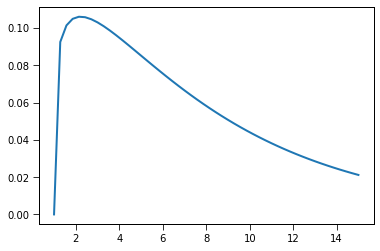

In [13]:
# alpha = 1.2 --> beta = 6.08743
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 0.124668*np.exp(-0.164273*x)*x**0.2
plt.plot(xxx+1, yyy)
plt.show()
# Still a bit too low

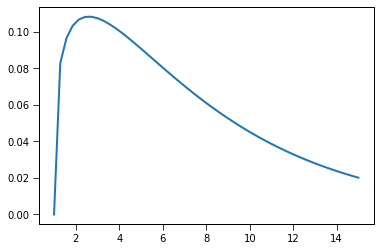

In [14]:
# alpha = 1.3 --> beta = 5.31203
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 0.127099*np.exp(-0.188252*x)*x**0.3
plt.plot(xxx+1, yyy)
plt.show()
# Meh

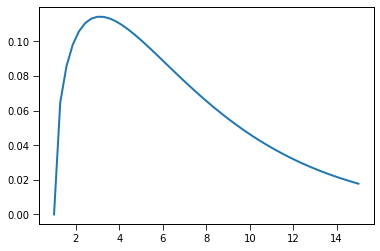

In [15]:
# alpha = 1.5 --> beta = 4.23352
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 0.12954*np.exp(-0.23621*x)*x**0.5
plt.plot(xxx+1, yyy)
plt.show()
# Slechter

In [ ]:
# Ik heb voor nu alpha = 1.1 en bijhorende beta = 7.12789 gekozen.